In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
import eispac
import dkist
import reproject
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

from ndcube import NDCube

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker



In [2]:
dkist_vbi_data_dir_1 = "../../src/DKIST/BWPNG/"
dkist_vbi_dataset_1 = dkist.Dataset.from_directory(dkist_vbi_data_dir_1)

/tmp/ipykernel_3544563/4025348973.py:2: DKISTDeprecationWarning: The from_directory function is deprecated and may be removed in a future version.
        Use load_dataset instead.
  dkist_vbi_dataset_1 = dkist.Dataset.from_directory(dkist_vbi_data_dir_1)


In [130]:
dkist_vbi_dataset_1[0,0][1].wcs

SlicedLowLevelWCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): (4096, 4096)

Pixel Dim  Axis Name                  Data size  Bounds
        0  helioprojective latitude        4096  None
        1  helioprojective longitude       4096  None

World Dim  Axis Name                  Physical Type                   Units
        0  helioprojective latitude   custom:pos.helioprojective.lon  arcsec
        1  helioprojective longitude  custom:pos.helioprojective.lat  arcsec

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes

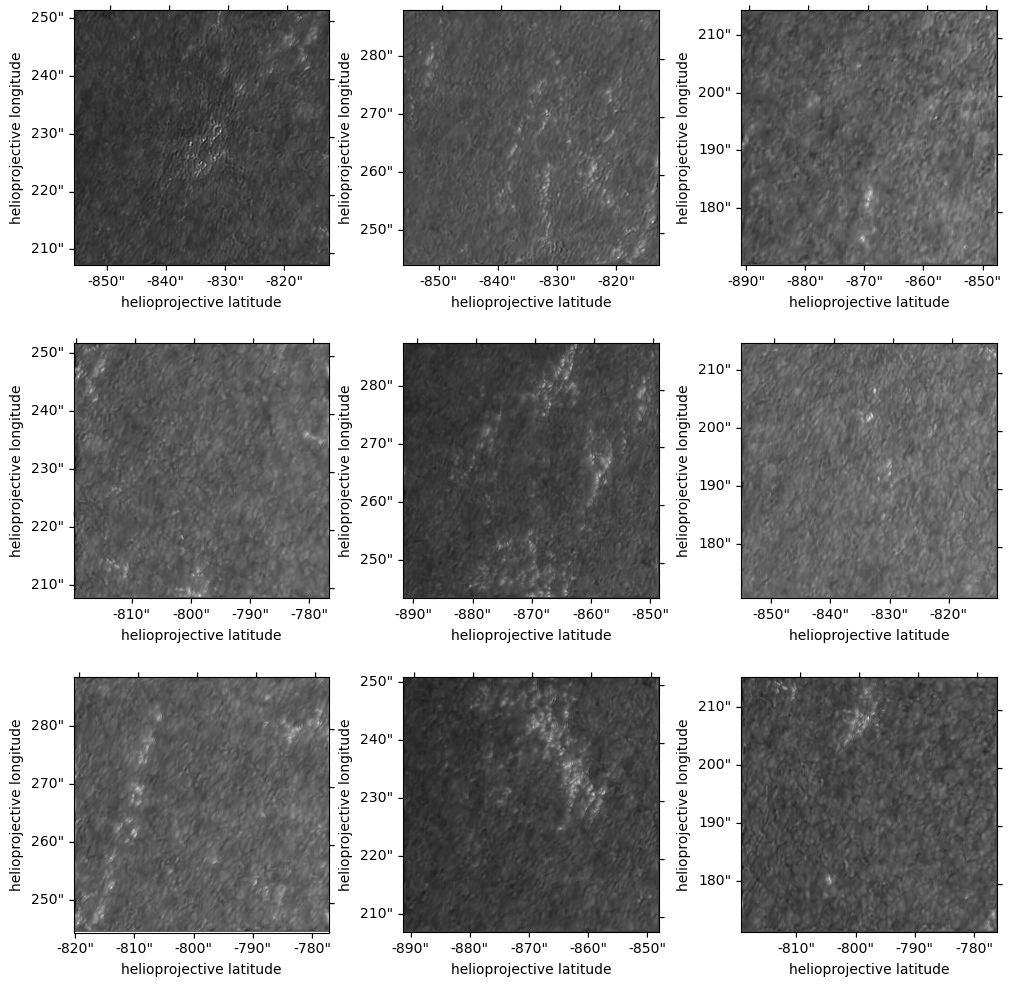

In [12]:
fig = plt.figure(figsize=(10,10),constrained_layout=True)

for ii in range(3):
    for jj in range(3):
        ax = fig.add_subplot(3,3,ii*3+jj+1,projection=dkist_vbi_dataset_1[ii,jj][1].wcs)
        ax.imshow(dkist_vbi_dataset_1[ii,jj][1].data,origin='lower',cmap='gray')

In [16]:
dkist_vbi_dataset_1_crop_flat = [d[1,100:-100,100:-100] for d in dkist_vbi_dataset_1.flat]

In [137]:
reference_wcs_ds1, shape_out_ds1 = find_optimal_celestial_wcs(
    [f.wcs for f in dkist_vbi_dataset_1_crop_flat],
    auto_rotate=True,
    projection='TAN',
)

In [138]:
reference_wcs_ds1, shape_out_ds1

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
 CRVAL : -834.3745917196568 229.61226764970567 
 CRPIX : 5352.361715194398 5464.047627691897 
 PC1_1 PC1_2  : 0.9999177608219318 0.012824647864714088 
 PC2_1 PC2_2  : -0.012824647864714088 0.9999177608219318 
 CDELT : -0.010539000050304568 0.010539000050304568 
 NAXIS : 0  0,
 (10930, 10691))

In [167]:
reference_wcs_ds1_center = reference_wcs_ds1.pixel_to_world(5352.361715194398,5464.047627691897)
reference_wcs_ds1_new_header = sunpy.map.make_fitswcs_header(shape_out_ds1,
                                       reference_wcs_ds1_center,
                                       scale=u.Quantity((0.010539000050304568,0.010539000050304568), unit=u.arcsec/u.pix))
# reference_wcs_ds1_new_header["pc1_1"] = reference_wcs_ds1.wcs.pc[0,0]
# reference_wcs_ds1_new_header["pc1_2"] = -reference_wcs_ds1.wcs.pc[0,1]
# reference_wcs_ds1_new_header["pc2_1"] = -reference_wcs_ds1.wcs.pc[1,0]
# reference_wcs_ds1_new_header["pc2_2"] = reference_wcs_ds1.wcs.pc[1,1]

In [168]:
reference_wcs_ds1_new_header

MetaDict([('wcsaxes', 2),
          ('crpix1', 5346.0),
          ('crpix2', 5465.5),
          ('cdelt1', 0.010539000050304568),
          ('cdelt2', 0.010539000050304568),
          ('cunit1', 'arcsec'),
          ('cunit2', 'arcsec'),
          ('ctype1', 'HPLN-TAN'),
          ('ctype2', 'HPLT-TAN'),
          ('crval1', -834.3852650185581),
          ('crval2', 229.6226706240483),
          ('lonpole', 180.0),
          ('latpole', 0.0),
          ('mjdref', 0.0),
          ('date-obs', '2022-10-21T19:34:52.113'),
          ('rsun_ref', 695700000.0),
          ('dsun_obs', 148914613846.44),
          ('hgln_obs', 0.001816905225668),
          ('hglt_obs', 5.3551462451582),
          ('naxis', 2),
          ('naxis1', 10691),
          ('naxis2', 10930),
          ('pc1_1', 1.0),
          ('pc1_2', -0.0),
          ('pc2_1', 0.0),
          ('pc2_2', 1.0),
          ('rsun_obs', 963.6324065071387)])

In [169]:
reference_wcs_ds1_new = WCS(reference_wcs_ds1_new_header)

In [170]:
mosaic_vbi_img, mosaic_footprint = reproject_and_coadd(
    dkist_vbi_dataset_1_crop_flat,
    reference_wcs_ds1_new,
    reproject_function=reproject_interp,
    shape_out=shape_out_ds1,
    roundtrip_coords=False,
)

In [175]:
dkist_vbi_430_mosaic_map = sunpy.map.Map(mosaic_vbi_img,reference_wcs_ds1_new)
dkist_vbi_430_mosaic_map = dkist_vbi_430_mosaic_map.submap([100,100]*u.pix,
                                                           top_right=[10500,10600]*u.pix)
np.isnan(dkist_vbi_430_mosaic_map.data).sum()

0

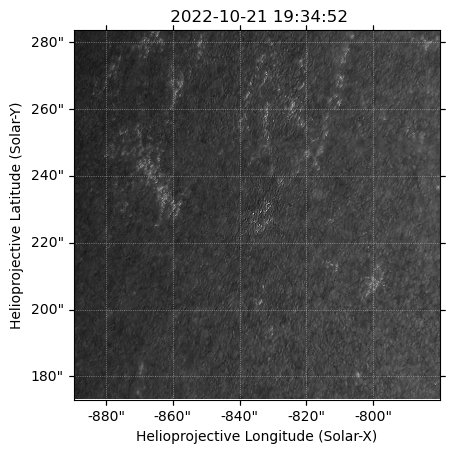

In [176]:
dkist_vbi_430_mosaic_map.plot()

In [177]:
dkist_vbi_430_mosaic_map.save("../../src/DKIST/vbi_mosaic/dkist_vbi_430_mosaic_map_new.fits",overwrite=True)

 [astropy.io.fits.verify]


In [29]:
dkist_vbi_data_dir_2 = "../../src/DKIST/BZNQO/"
dkist_vbi_dataset_2 = dkist.Dataset.from_directory(dkist_vbi_data_dir_2)

/tmp/ipykernel_3544563/1335969084.py:2: DKISTDeprecationWarning: The from_directory function is deprecated and may be removed in a future version.
        Use load_dataset instead.
  dkist_vbi_dataset_2 = dkist.Dataset.from_directory(dkist_vbi_data_dir_2)


In [31]:
dkist_vbi_dataset_2.shape

(2, 2)

In [32]:
dkist_vbi_dataset_2_0_crop_flat = [d[0,100:-100,100:-100] for d in dkist_vbi_dataset_2.flat]

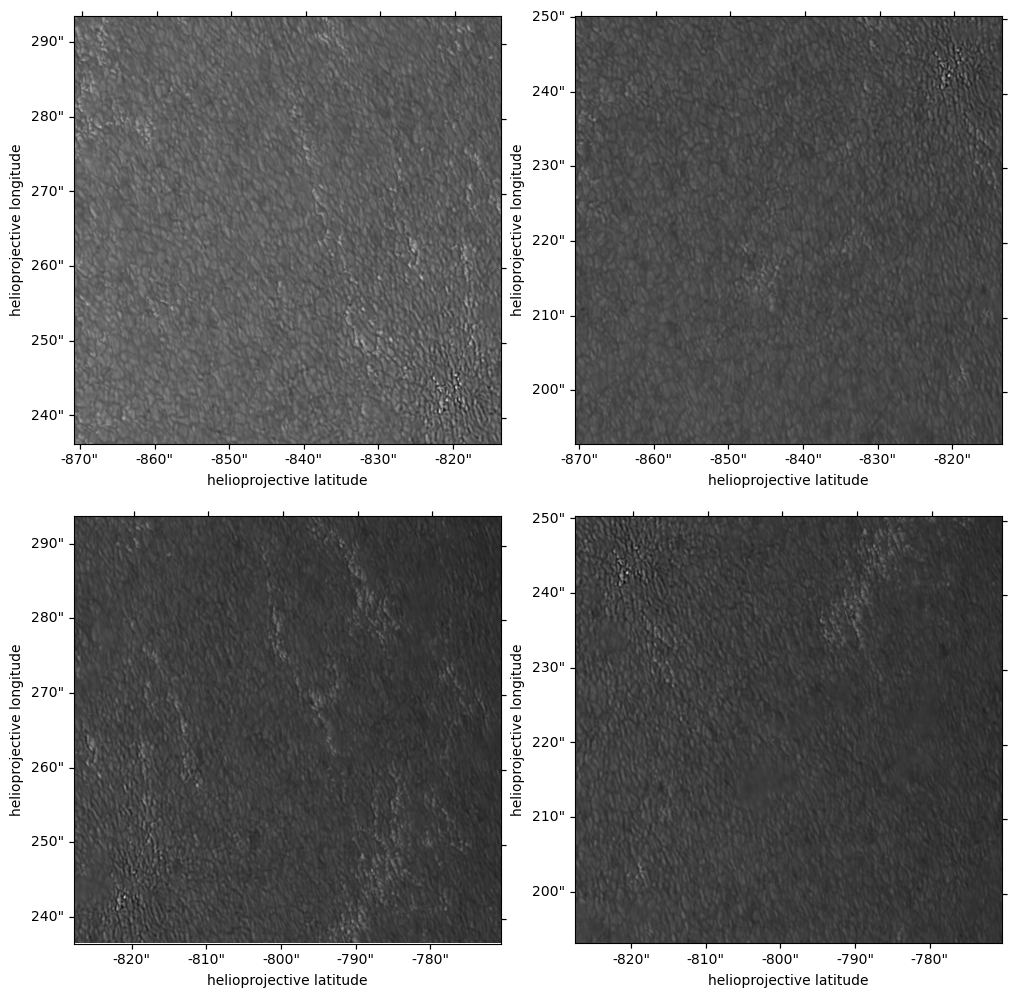

In [134]:
fig = plt.figure(figsize=(10,10),constrained_layout=True)

for ii in range(2):
    for jj in range(2):
        ax = fig.add_subplot(2,2,ii*2+jj+1,projection=dkist_vbi_dataset_2[ii,jj][0].wcs)
        ax.imshow(dkist_vbi_dataset_2_0_crop_flat[ii*2+jj].data,origin='lower',cmap='gray')

In [33]:
reference_wcs_ds2_0, shape_out_ds2_0 = find_optimal_celestial_wcs(
    [f.wcs for f in dkist_vbi_dataset_2_0_crop_flat],
    auto_rotate=True,
)

In [131]:
reference_wcs_ds2_0, shape_out_ds2_0

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
 CRVAL : -0.2275712190585149 0.06802221912931164 
 CRPIX : 3415.888999991823 3426.29283074665 
 PC1_1 PC1_2  : 0.9999883706404536 0.0048227154022076 
 PC2_1 PC2_2  : -0.0048227154022076 0.9999883706404536 
 CDELT : -4.078079506101772e-06 4.078079506101772e-06 
 NAXIS : 0  0,
 (6852, 6831))

In [34]:
mosaic_vbi_img_705_0, mosaic_footprint_705_0 = reproject_and_coadd(
    dkist_vbi_dataset_2_0_crop_flat,
    reference_wcs_ds2_0,
    reproject_function=reproject_interp,
    shape_out=shape_out_ds2_0,
    roundtrip_coords=False,
)

In [35]:
dkist_vbi_705_mosaic_map_0 = sunpy.map.Map(mosaic_vbi_img_705_0,reference_wcs_ds2_0)

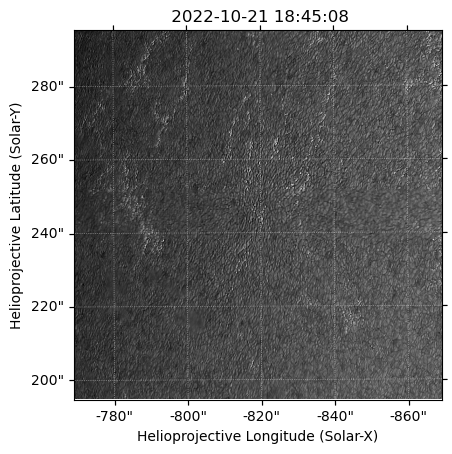

In [36]:
dkist_vbi_705_mosaic_map_0.plot()

In [37]:
dkist_vbi_705_mosaic_map_0.save("../../src/DKIST/vbi_mosaic/dkist_vbi_705_mosaic_map_0.fits",overwrite=True)

In [38]:
dkist_vbi_dataset_2_1_crop_flat = [d[1,100:-100,100:-100] for d in dkist_vbi_dataset_2.flat]

In [39]:
reference_wcs_ds2_1, shape_out_ds2_1 = find_optimal_celestial_wcs(
    [f.wcs for f in dkist_vbi_dataset_2_1_crop_flat],
    auto_rotate=True,
)

In [40]:
mosaic_vbi_img_705_1, mosaic_footprint_705_1 = reproject_and_coadd(
    dkist_vbi_dataset_2_1_crop_flat,
    reference_wcs_ds2_1,
    reproject_function=reproject_interp,
    shape_out=shape_out_ds2_1,
    roundtrip_coords=False,
)

In [41]:
dkist_vbi_705_mosaic_map_1 = sunpy.map.Map(mosaic_vbi_img_705_1,reference_wcs_ds2_1)

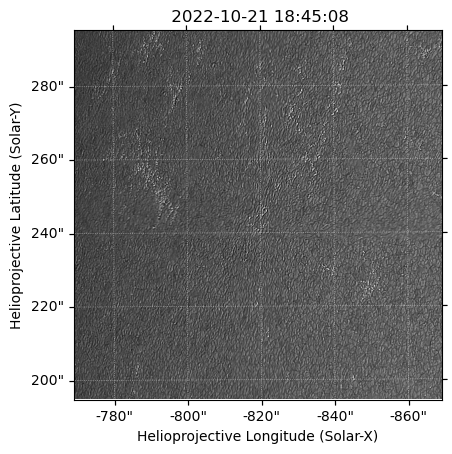

In [42]:
dkist_vbi_705_mosaic_map_1.plot()

In [43]:
dkist_vbi_705_mosaic_map_1.save("../../src/DKIST/vbi_mosaic/dkist_vbi_705_mosaic_map_1.fits",overwrite=True)

In [88]:
dkist_vbi_data_dir_3 = "../../src/DKIST/AQQEY/"
dkist_vbi_dataset_3 = dkist.Dataset.from_asdf(os.path.join(dkist_vbi_data_dir_3,"VBI_L1_20221021T184520_AQQEY.asdf"))

/tmp/ipykernel_3544563/3600136820.py:2: DKISTDeprecationWarning: The from_asdf function is deprecated and may be removed in a future version.
        Use load_dataset instead.
  dkist_vbi_dataset_3 = dkist.Dataset.from_asdf(os.path.join(dkist_vbi_data_dir_3,"VBI_L1_20221021T184520_AQQEY.asdf"))


In [89]:
dkist_vbi_dataset_3

This Dataset has 3 pixel and 3 world dimensions

dask.array<reshape, shape=(504, 4096, 4096), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

Pixel Dim  Axis Name                  Data size  Bounds
        0  time                             504  None
        1  helioprojective longitude       4096  None
        2  helioprojective latitude        4096  None

World Dim  Axis Name                  Physical Type                   Units
        0  time                       time                            s
        1  helioprojective longitude  custom:pos.helioprojective.lat  arcsec
        2  helioprojective latitude   custom:pos.helioprojective.lon  arcsec

Correlation between pixel and world axes:

             Pixel Dim
World Dim    0    1    2
        0  yes   no   no
        1  yes  yes  yes
        2  yes  yes  yes

In [91]:
dkist_vbi_dataset_3[344,:,:].meta["headers"]["DATE-AVG"]

2022-10-21T19:20:16.813503


In [117]:
dkist_vbi_Halpha_mosaic_map_344 = sunpy.map.Map(dkist_vbi_dataset_3[344,:,:].data,WCS(dkist_vbi_dataset_3[344,:,:].meta["headers"][0]))

Set MJD-BEG to 59873.805750 from DATE-BEG.
Set MJD-AVG to 59873.805750 from DATE-AVG.
Set MJD-END to 59873.805750 from DATE-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706700 from OBSGEO-[XYZ].
Set OBSGEO-H to     3063.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


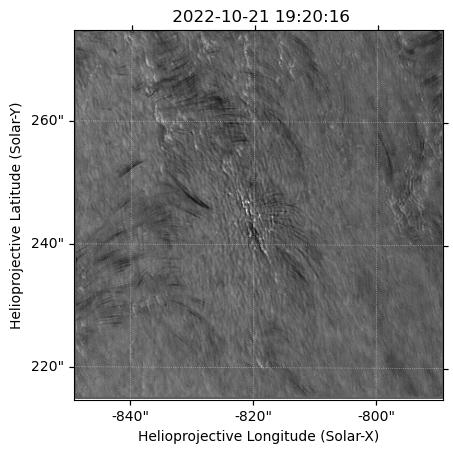

In [119]:
dkist_vbi_Halpha_mosaic_map_344.plot()

In [128]:
dkist_vbi_Halpha_mosaic_map_344.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : -0.23183446427713 0.063864871502736 
CRPIX : 999.36026869651 1034.0579490381 
PC1_1 PC1_2  : 0.9475710114292 -0.0045998256061564 
PC2_1 PC2_2  : 0.0047146525205934 0.94727421502119 
CDELT : 4.3050417055686e-06 4.3050417055686e-06 
NAXIS : 4096  4096

In [127]:
dkist_vbi_Halpha_mosaic_map_344.save("../../src/DKIST/vbi_mosaic/dkist_vbi_Halpha_mosaic_map_344.fits",overwrite=True)